# Skin Cancer
kaggle dataset: https://www.kaggle.com/datasets/dhanushanumakonda/skin-cancer-using-knn-accuracy-9967?select=skin_cancer.csv

Features:
- **lesion_id**
- **image_id**
- **dx**: types of Skin Lesions
 - Cancerous
    - MEL: Melanoma
    - BCC: Basal cell carcinoma
    - AKIEC: Actinic keratoses
 - Non-Cancerous
    - NV: Melanocytic nevus
    - BKL: Benign keratosis
    - DF: Dermatofibroma
    - VASC: Vascular lesion
- **dx_type**
- **age**
- **sex**
- **localization**

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [66]:
skin = pd.read_csv('skin_cancer.csv')

In [67]:
skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [68]:
skin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


# Data Cleaning

In [69]:
#drop 'lesion_id' and 'image_id', not usefull for classification
skin = skin.drop(['lesion_id', 'image_id'], axis = 1)

In [70]:
skin.head()

,dx,dx_type,age,sex,localization
0,bkl,histo,80.0,male,scalp
1,bkl,histo,80.0,male,scalp
2,bkl,histo,80.0,male,scalp
3,bkl,histo,80.0,male,scalp
4,bkl,histo,75.0,male,ear


In [71]:
skin['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [72]:
skin['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [73]:
skin['age'].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: age, dtype: int64

In [74]:
skin['age'].isnull().value_counts()

False    9958
True       57
Name: age, dtype: int64

In [75]:
skin[skin['age']==0.0].groupby('dx').count()

,dx_type,age,sex,localization
dx,,,,
bkl,5,5,5,5
nv,30,30,30,30
vasc,4,4,4,4


In [ ]:
"""
As it is not rare a child be born with skin disease {bkl,nv,vasc}, we don't consider age = 0 as error
But we have 57 rows with unknown age filed
we can drop these rows, or impute them as follows:
lets first 
  1 - visualize the age distribution based on the 'sex', and 'bx'
  2 - find the median of each group
  3 - fill the null value with the associated median
"""

In [76]:
skin['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [77]:
#drop sex with unknown value
skin = skin[skin['sex'] != 'unknown']

<AxesSubplot:xlabel='dx', ylabel='age'>

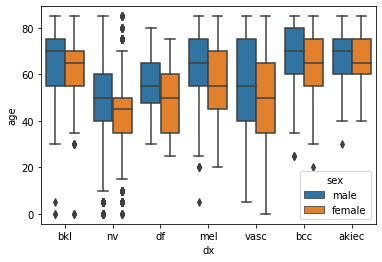

In [78]:
#plot age based on dx and sex
sns.boxplot(x='dx', y='age', hue='sex', data=skin)

In [79]:
#find the age median of different groups, sex = 'male'
skin[skin['sex']=='male'].groupby(['dx'])['age'].median()

dx
akiec    70.0
bcc      70.0
bkl      70.0
df       55.0
mel      65.0
nv       50.0
vasc     55.0
Name: age, dtype: float64

In [80]:
#find the age median of different groups, sex = 'female'
skin[skin['sex']=='female'].groupby(['dx'])['age'].median()

dx
akiec    65.0
bcc      65.0
bkl      65.0
df       50.0
mel      55.0
nv       45.0
vasc     50.0
Name: age, dtype: float64

In [81]:
def impute_age(d):
  age = d[0]
  sex = d[1]
  dx = d[2]
  if age is None:
    if dx == 'bkl':
      if sex == 'male':
        return 70
      else:
        return 65
    elif dx == 'nv':
      if sex == 'male':
        return 50
      else:
        return 45
    elif dx == 'df':
      if sex == 'male':
        return 55
      else:
        return 50
    elif dx == 'mel':
      if sex == 'male':
        return 65
      else:
        return 55
    elif dx == 'vasc':
      if sex == 'male':
        return 55
      else:
        return 50
    elif dx == 'bcc':
      if sex == 'male':
        return 70
      else:
        return 65
    elif dx == 'akiec':
      if sex == 'male':
        return 70
      else:
         return 65
  else:
    return age

In [82]:
#impute the age column with missing value
skin['age'] = skin[['age', 'sex', 'dx']].apply(impute_age, axis=1)

In [83]:
skin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9958 entries, 0 to 10014
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dx            9958 non-null   object 
 1   dx_type       9958 non-null   object 
 2   age           9948 non-null   float64
 3   sex           9958 non-null   object 
 4   localization  9958 non-null   object 
dtypes: float64(1), object(4)
memory usage: 724.8+ KB


In [84]:
skin['localization'].value_counts()

back               2190
lower extremity    2077
trunk              1401
upper extremity    1118
abdomen            1020
face                745
chest               407
foot                316
unknown             187
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [85]:
#drop rows with localization = 'unknown'
skin = skin[skin['localization'] != 'unknown']

In [ ]:
"""
for implementing knn algorithm on the skin dataset, 
we need to convert categorical features using one-hot-encoding
"""

In [86]:
skin['sex'] = pd.get_dummies(skin.sex, drop_first=True)

In [87]:
skin['sex'].value_counts()

1    5314
0    4457
Name: sex, dtype: int64

In [88]:
#temp = pd.get_dummies(skin.dx)

In [50]:
#temp

,akiec,bcc,bkl,df,mel,nv,vasc
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
10010,1,0,0,0,0,0,0
10011,1,0,0,0,0,0,0
10012,1,0,0,0,0,0,0
10013,1,0,0,0,0,0,0


In [51]:
# for col in temp.columns:
#   skin[col] = temp[col]

In [52]:
#skin.head()

,dx,dx_type,age,sex,localization,bcc,bkl,df,mel,nv,vasc,akiec
0,bkl,histo,80.0,1,scalp,0,1,0,0,0,0,0
1,bkl,histo,80.0,1,scalp,0,1,0,0,0,0,0
2,bkl,histo,80.0,1,scalp,0,1,0,0,0,0,0
3,bkl,histo,80.0,1,scalp,0,1,0,0,0,0,0
4,bkl,histo,75.0,1,ear,0,1,0,0,0,0,0


In [89]:
localiz = pd.get_dummies(skin.localization)
for col in localiz:
  skin[col] = localiz[col]

In [90]:
skin.head()

,dx,dx_type,age,sex,localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,upper extremity
0,bkl,histo,80.0,1,scalp,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,bkl,histo,80.0,1,scalp,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,bkl,histo,80.0,1,scalp,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,bkl,histo,80.0,1,scalp,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,bkl,histo,75.0,1,ear,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [91]:
dx_typ = pd.get_dummies(skin.dx_type)
for col in dx_typ:
  skin[col] = dx_typ[col]

In [92]:
skin.head()

,dx,dx_type,age,sex,localization,abdomen,acral,back,chest,ear,...,hand,lower extremity,neck,scalp,trunk,upper extremity,confocal,consensus,follow_up,histo
0,bkl,histo,80.0,1,scalp,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,bkl,histo,80.0,1,scalp,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,bkl,histo,80.0,1,scalp,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,bkl,histo,80.0,1,scalp,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,bkl,histo,75.0,1,ear,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [93]:
#drop original columns {dx, dx_type, localization}
skin.drop(['dx_type', 'localization'], axis=1, inplace=True)

In [101]:
skin.head()

,dx,age,sex,abdomen,acral,back,chest,ear,face,foot,...,hand,lower extremity,neck,scalp,trunk,upper extremity,confocal,consensus,follow_up,histo
0,bkl,80.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,bkl,80.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,bkl,80.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,bkl,80.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,bkl,75.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [102]:
len(skin)

9771

In [103]:
skin.dropna(inplace=True)

In [104]:
len(skin)

9761

# Train Test Split

In [95]:
from sklearn.model_selection import train_test_split

In [105]:
X = skin.drop('dx',axis=1)
y= skin['dx']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [106]:
y.value_counts()

nv       6491
mel      1101
bkl      1076
bcc       509
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [107]:
#normalizing age feature to be in range(0,1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

# Training and Predicting

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [108]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [109]:
pred = knn.predict(X_test)

In [110]:
print(confusion_matrix(y_test,pred))

[[  36   12   14    0   15   16    0]
 [  28   38   33    3   20   30    0]
 [  66   29  124    4   39   64   10]
 [   3    0    7   13    2    9    0]
 [  66   31   48    6   69  135    0]
 [  74   54   53   13   70 1650    4]
 [   2    1   16    0    1   14    7]]


In [111]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

       akiec       0.13      0.39      0.20        93
         bcc       0.23      0.25      0.24       152
         bkl       0.42      0.37      0.39       336
          df       0.33      0.38      0.36        34
         mel       0.32      0.19      0.24       355
          nv       0.86      0.86      0.86      1918
        vasc       0.33      0.17      0.23        41

    accuracy                           0.66      2929
   macro avg       0.38      0.37      0.36      2929
weighted avg       0.67      0.66      0.66      2929



# Choosing a K Value

lets check how the k number may affect the accuracy

In [119]:
error_rate = []

# Will take some time
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

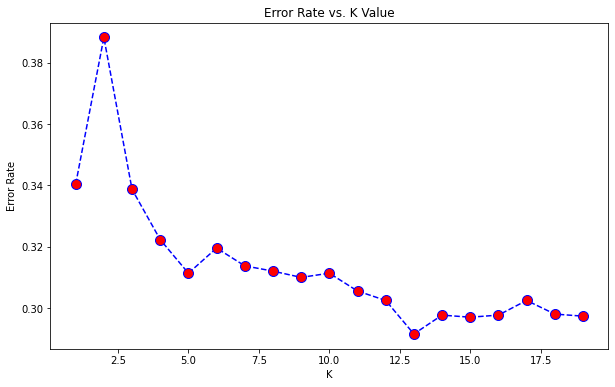

In [120]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [133]:
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=13')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=13


[[  11   12   18    0   24   28    0]
 [   7   31   24    0   35   55    0]
 [  14   25  135    1   60  101    0]
 [   0    1    6    8    2   17    0]
 [  17   19   31    0  107  181    0]
 [   4   10   40    7   74 1783    0]
 [   0    1   10    0    2   28    0]]


              precision    recall  f1-score   support

       akiec       0.21      0.12      0.15        93
         bcc       0.31      0.20      0.25       152
         bkl       0.51      0.40      0.45       336
          df       0.50      0.24      0.32        34
         mel       0.35      0.30      0.32       355
          nv       0.81      0.93      0.87      1918
        vasc       0.00      0.00      0.00        41

    accuracy                           0.71      2929
   macro avg       0.39      0.31      0.34      2929
weighted avg       0.66      0.71      0.68      2929



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#As seen the accuracy improved by setting k =13, but none of 'vasc' class clssified correctly 